# Anlyse [`HiBench`](https://github.com/Intel-bigdata/HiBench) Measurements on [Gilgamesh](https://kb.hlrs.de/platforms/index.php/Urika_GX) (Cray URIKA GX)

## Prepare

### Get access to Mesos monitor

**Note**: To track the usage of Gilgamesh nodes, open http://127.0.0.1:5050/ in the [about:profiles](Gilgamesh profile). Authentificate with your username and password: `less /security/secrets/$USER.mesos`. 

In [4]:
!ssh gilgamesch 'echo -e " login:$(whoami)\npasswd:$(cat /security/secrets/$USER.mesos)"' 2> /dev/null

Clean up old measurements

In [69]:
!ssh gilgamesch 'rm -rf report/hibench.report' #2> /dev/null

bind: Address already in use
channel_setup_fwd_listener_tcpip: cannot listen to port: 8080
Could not request local forwarding.


## Get Measurements

In [1]:
import pandas
def read_hibench_report(filename, scale, ncores):
    # recent_measurements.columns = map(lambda : str.lower, recent_measurements.columns)
    recent_measurements = pandas.read_csv(filename, sep="\s+")
    recent_measurements.rename(columns={"Type" : "name", "Input_data_size" : "data_size", "Duration(s)": "duration", "Throughput(bytes/s)":"throughput", "Throughput/node":"node_throughput"}, inplace=True)
    recent_measurements.insert(1, 'scale', scale)
    recent_measurements.insert(2, 'ncores', ncores)
    recent_measurements['throughput'] = recent_measurements['throughput']/(1024**2) # convert B/s to MB/s
    recent_measurements['data_size'] = recent_measurements['data_size']/(1024**2) # convert B to MB
    return recent_measurements

### Data Acquisition & Wrangling 1: Get data from multiple reports on cluster

In [2]:
%%bash
# rm -rf ./data/*
mkdir -p ./data2
scp gilgamesch:~/proj/hidalgo/wp3/soft/HiBench/report/summary/hibench*.report ./data2
# for filename in `ls ./data`
# do
#     NAME=$(echo $filename | cut -f2 -d-)
#     NCORES=$(echo $filename | cut -f3 -d- | cut -f1 -d.)
# done

In [4]:
import os
import re
import io

measurements_loacal_folder = r'data2'

re_filename = re.compile("hibench-(?P<scale>.+)-(?P<ncores>[0-9]+)\.report")
measurements = None
for file in os.listdir(measurements_loacal_folder):
    match_filename = re_filename.match(file)
    if match_filename:
        recent_measurements = read_hibench_report(os.path.join(measurements_loacal_folder, match_filename.group(0)),
                                                  match_filename.group('scale'), int(match_filename.group('ncores')))
        if measurements is None:
            measurements = recent_measurements
        else:
            measurements = measurements.append( recent_measurements, ignore_index=True )
measurements.head(1)

,name,scale,ncores,Date,Time,data_size,duration,throughput,node_throughput
0,ScalaSparkSleep,tiny,72,2019-10-10,17:26:48,0.0,8.801,0.0,0


In [5]:
measurements = measurements.groupby(['scale','name','ncores'], as_index=False).agg({'duration':'mean', 'data_size':'mean', 'throughput':'mean', 'node_throughput':'mean'})
# measurements=measurements[measurements['scale']=='large']

### Data Acquisition & Wrangling 2: Get measurements from latest run on cluster only

In [91]:
%%capture --no-stderr benchmark_data
!ssh gilgamesch "cat ~/proj/hidalgo/wp3/soft/HiBench/report/hibench.report" 2> /dev/null | sed 's/[ \t]*$//;s/[[:space:]]\{1,\}/,/g'

In [6]:
numproc=288

import io
recent_measurements = read_hibench_report(io.StringIO(benchmark_data.stdout),
                                          scale='tiny', ncores=288)


recent_measurements.rename(columns={"Type" : "name", "Input_data_size" : "data_size", "Duration(s)": "duration", "Throughput(bytes/s)":"throughput", "Throughput/node":"node_throughput"}, inplace=True)
# recent_measurements['numproc']=72
recent_measurements.insert(1, 'numproc', 288)
recent_measurements.sort_values(by='name')

NameError: name 'benchmark_data' is not defined

Load and wrangle measurements

In [7]:
filename_measurements = '~/Downloads/gilgamesch-HiBench.csv'

old_measures = pandas.read_csv(filename_measurements, header=0)

# measures = recent_measurements
measures = old_measures.append( recent_measurements, ignore_index=True ).drop_duplicates()

# # Filter measures from succeeded runs only
# measures = measures[measures.error == 0].sort_values(by=['mode','numproc'])

# Store all measurements in file
measures.to_csv(filename_measurements, index=False)

measures.sort_values(by=['name', 'numproc']).head(1)

FileNotFoundError: [Errno 2] File b'/home/hpcgogol/Downloads/gilgamesch-HiBench.csv' does not exist: b'/home/hpcgogol/Downloads/gilgamesch-HiBench.csv'

## Plot results

### Plot elapsed time via number of processes (version 1)

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
measurements.sort_values(by=['ncores']).groupby('name').plot(x='ncores', y='duration', loglog=True, ax=ax)
measurements.name.unique()

array(['GradientBoostingTree', 'LDA', 'LinearRegression',
       'LogisticRegression', 'PCA', 'RandomForest', 'SVD', 'SVM',
       'ScalaSparkAggregation', 'ScalaSparkBayes', 'ScalaSparkJoin',
       'ScalaSparkKmeans', 'ScalaSparkPagerank', 'ScalaSparkScan',
       'ScalaSparkSleep', 'ScalaSparkSort', 'ScalaSparkWordcount',
       'ScalaSparkNWeight', 'ScalaSparkTerasort'], dtype=object)

### Plot elapsed time via number of processes (version 2)

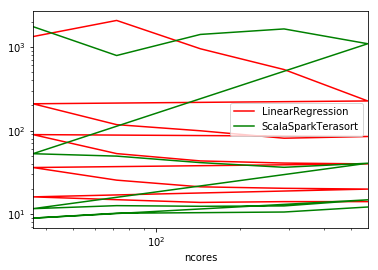

In [9]:
fig, ax = plt.subplots()
colors=iter(list('rgbym'*10))
for label, df in measurements.groupby('name'):
    if label in ('LinearRegression', 'ScalaSparkTerasort'):
        df.plot.line(x='ncores',y='duration', ax=ax, label=label, loglog=True, c=next(colors)) # scatter
plt.legend()

### Plot elapsed time and speedup (in [`bokeh`](https://docs.bokeh.org/en/latest/))

In [10]:
cluster_ppn = 36

elapsedtime_metric = lambda df: df['duration']
memory_metric = lambda df: df['ram']
io_metric = lambda df: df['io_in']+df['io_out']
def speedup_metric(df):
    """Semi-speedup"""
    min_raw = df.loc[df['ncores'].idxmin()]
    return (min_raw['duration']*min_raw['ncores'])/df['duration']
def node_speedup_metric(df):
    """Semi-speedup"""
    min_raw = df[df['ncores']==cluster_ppn].iloc[0]
    return (min_raw['duration']*min_raw['ncores'])/df['duration']
def efficiency_metric(df):
    """Semi-efficiency"""
    min_raw = df.loc[df['ncores'].idxmin()]
    return (min_raw['duration']*min_raw['ncores'])/df['duration']/df['ncores']
def node_efficiency_metric(df):
    """Semi-efficiency"""
    min_raw = df[df['ncores']==cluster_ppn].iloc[0]
    return (min_raw['duration']*min_raw['ncores'])/df['duration']/df['ncores']

In [11]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import Range1d, axes

measurements_advanced = measurements[measurements['name'] == 'LinearRegression'].sort_values(by='ncores')

# Plot some metric for all measurements
colors=iter(['red', 'green', 'blue','cyan', 'magenta', 'black']*10) # iter(list('rgbym'))

p1 = figure(title="Elapsed time (benchmark on Gilgamesch)", y_axis_type="log", x_axis_type="log",)
p1.grid.grid_line_alpha=0.3
p1.xaxis.axis_label = '# of cores'
p1.yaxis.axis_label = 'Elapsed time, s'

metric=elapsedtime_metric
for label, df in measurements.sort_values(by='ncores').groupby('name'):
    color = next(colors)
    p1.line(df['ncores'], metric(df), color=color, legend=df['name'].iloc[0])
    p1.circle(df['ncores'], metric(df), color=color, fill_color='white', size=6, legend=df['name'].iloc[0])
p1.legend.location = "top_right"


# Plot speedup for advanced mode
p2 = figure(title="Speedup  w.r.t. single 24-core node (Hazelhen)")
p2.grid.grid_line_alpha = 0.5

p2.xaxis.axis_label = '# of cores'
p2.yaxis.axis_label = 'Speedup'

p2.ygrid.band_fill_color = "olive"
p2.ygrid.band_fill_alpha = 0.1

p2.line(measurements_advanced['ncores'], node_speedup_metric(measurements_advanced), legend='`advanced` mode')
p2.y_range=Range1d(0, max(node_speedup_metric(measurements_advanced)))

max_nprocs=measurements_advanced['ncores'].max()
p2.x_range = Range1d(0, max_nprocs)
p2.extra_x_ranges = {"ClusterNodes": Range1d(start=0, end=max_nprocs/cluster_ppn)}
p2.add_layout(axes.LinearAxis(x_range_name="ClusterNodes", axis_label="# of nodes"), 'above')

# draw linear speedup line
p2.line([1,max_nprocs], [1,max_nprocs], color='gray', line_dash='dashed', legend='linear speedup')
p2.legend.location = "bottom_right"

# Plot efficiency for advanced mode
p3 = figure(title="Efficiency w.r.t. single 24-core node (Hazelhen)")
# p2.grid.grid_line_alpha = 0

p3.xaxis.axis_label = '# of cores'
p3.yaxis.axis_label = 'Efficiency'

p3.ygrid.band_fill_color = "olive"
p3.ygrid.band_fill_alpha = 0.1

max_nprocs=measurements_advanced['ncores'].max()
p3.x_range = Range1d(0, max_nprocs)
p3.extra_x_ranges = {"ClusterNodes": Range1d(start=0, end=max_nprocs/cluster_ppn)}
p3.add_layout(axes.LinearAxis(x_range_name="ClusterNodes", axis_label="# of nodes"), 'above')

p3.line(measurements_advanced['ncores'], node_efficiency_metric(measurements_advanced), legend='`advanced` mode')
p3.legend.location = "top_right"

measurements_advanced = measurements[measurements['name'] == 'LinearRegression'].sort_values(by='ncores')

output_file("pflee-hazelhen-20190924.html", title="PFlee benchmark on Hazelhen")
output_notebook()
show(gridplot([[p1,p2,p3]], plot_width=600, plot_height=400))


Loading BokehJS ...

In [12]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import Range1d, axes
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import Row, Column, gridplot
# output_notebook()

from bokeh.palettes import Dark2_5 as palette
import itertools 
# # Plot some metric for all measurements
# colors = itertools.cycle(palette)

output_notebook()

def scaling_plot(measurements, axis_type='log'): #linear
    row = measurements.iloc[0]
    title = 'HiBench.{1} {0} test on Urika GX'.format(row['scale'], row['name'])
    y_axis_data = 'throughput' # 'duration'

    fig = figure(title=title, sizing_mode='scale_width', y_axis_type=axis_type, x_axis_type=axis_type,)
    fig.grid.grid_line_alpha = 0.75
    fig.xaxis.axis_label = '# of cores'
    fig.yaxis.axis_label = 'Elapsed time, s'
    fig.xaxis.ticker = measurements.ncores

    fig.line(measurements['ncores'], measurements[y_axis_data])
    fig.circle(measurements['ncores'], measurements[y_axis_data], fill_color='white', size=6)
    # fig.legend.location = "top_right"

#     fig.y_range.start = 0
#     fig.y_range=Range1d(0, max(node_speedup_metric(measurements_advanced)))
    fig.ygrid.band_fill_color = "olive"
    fig.ygrid.band_fill_alpha = 0.1

#     min_ncores, max_ncores=measurements['ncores'].min(), measurements['ncores'].max()
#     delta_ncores = .05*(max_ncores - min_ncores)
#     fig.x_range = Range1d(min_ncores - delta_ncores, max_ncores+delta_ncores)
#     fig.extra_x_ranges = {"ClusterNodes": Range1d(start=0, end=max_nprocs/cluster_ppn)}
#     fig.add_layout(axes.LinearAxis(x_range_name="ClusterNodes", axis_label="# of nodes"), 'above')
    
    return fig

measurements = measurements.groupby(['scale','name','ncores'], as_index=False).agg({'duration':'mean', 'data_size':'mean', 'throughput':'mean', 'node_throughput':'mean'})
plots_table = measurements.groupby(['scale', 'name'])['scale', 'name', 'ncores', 'duration', 'throughput'].apply(scaling_plot)


scale = 'huge' # 'large' # 'tiny'# 'small' # 
names = measurements[measurements['scale'] == scale]['name'].unique()
# 'GradientBoostingTree' 'PCA' 'RandomForest' 'SVD' 'ScalaSparkBayes' 'ScalaSparkJoin' 'ScalaSparkNWeight' 'ScalaSparkPagerank' 'ScalaSparkScan' 'ScalaSparkSleep' 
# names = ['LDA', 'LinearRegression', 'LogisticRegression', 'SVM', 'ScalaSparkAggregation', 'ScalaSparkKmeans', 'ScalaSparkSort', 'ScalaSparkTerasort', 'ScalaSparkWordcount']
from toolz import partition_all
L = plots_table.loc[scale].loc[names].values.tolist()
grid = list(partition_all(3, L))

# output_file("pflee-hazelhen-20190924.html", title="Benchmark on Hazelhen")
show(gridplot(grid, plot_width=400, plot_height=400))

Loading BokehJS ...

In [13]:
# measurements_avg = measurements.groupby(['scale','name','ncores'], as_index=False).agg({'duration':'mean', 'data_size':'mean', 'throughput':'mean', 'node_throughput':'mean'})
def fix_column_name(name):
    re_col_name=re.compile(r"\(\'([a-zA-Z0-9]+)\', (\'([a-zA-Z]+)\'\)|[0-9]+)")
    m = re_col_name.match(name)
    if m: return "{1}".format(m.group(1),m.group(2))
    return name

def to_profile_tables(df, filed='duration'):
#     x = pandas.DataFrame(measurements.pivot_table(index=['name','ncores'], columns='scale', values=['duration']).to_records())
#     x.columns = map(fix_column_name, x.columns)
    df_profile = pandas.DataFrame(df.pivot_table(index=['name'],#['name', 'data_size'],
                                                 columns='ncores', values=['duration']).to_records())
    df_profile.columns = map(fix_column_name, df_profile.columns)
    return df_profile

measurements = measurements.groupby(['scale','name','ncores'], as_index=False).agg({'duration':'mean', 'data_size':'mean', 'throughput':'mean', 'node_throughput':'mean'})

import os
from IPython.display import display, HTML

# duration_tables = measurements.groupby(['scale'])['scale', 'name', 'ncores', 'duration', 'throughput'].apply(to_profile_tables)
# for df_profile in duration_tables.loc[measurements['scale'].unique()].values:
#     print(display(HTML(df_profile.to_html())))
for scale in measurements['scale'].unique():
    print(scale)
    df_profile = to_profile_tables(pandas.DataFrame(measurements[measurements['scale'] == scale]))
#     print(display(HTML(df_profile.to_html())))
    df_profile.to_csv('/home/hpcgogol/proj/hidalgo/doc/D3.3/figs/%s.org' % scale, index_label=False, sep='|', header=True,
                      line_terminator='|' + os.linesep, float_format='%.3f')


# x=measurements[measurements['scale'] in ('small, ''large')]
# pandas.DataFrame(x.pivot_table(index=['name'], columns=['scale','ncores'], values=['duration']).to_records())


gigantic
huge
large
small
tiny


In [14]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import Range1d, axes
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import Row, Column, gridplot
# output_notebook()

from bokeh.palettes import Dark2_5 as palette
import itertools 

output_notebook()

def scaling_plot(measurements, axis_type='linear', y_axis_data = ('throughput', 'Throughput, MB/s')): #'log', ('duration', 'Duration, s')
    y_axis_field, y_axis_label = y_axis_data

    row = measurements.iloc[0]
    title = 'HiBench.{name} test'.format(name=row['name'])

    # Plot some metric for all measurements
    colors = itertools.cycle(palette)
    fig = figure(title=title, sizing_mode='scale_width', y_axis_type=axis_type, x_axis_type=axis_type,)

    fig.grid.grid_line_alpha = 0.75
    fig.ygrid.band_fill_color = "olive"
    fig.ygrid.band_fill_alpha = 0.1

    min_ncores, max_ncores=measurements['ncores'].min(), measurements['ncores'].max()
    fig.xaxis.axis_label = '# of cores'
    fig.xaxis.ticker = measurements.ncores
    fig.x_range = Range1d(0, max_ncores+cluster_ppn)
    fig.extra_x_ranges = {"ClusterNodes": Range1d(start=0, end=max_ncores/cluster_ppn+1)}
    fig.add_layout(axes.LinearAxis(x_range_name="ClusterNodes", axis_label="# of nodes", ticker = measurements.ncores/cluster_ppn), 'above')

    fig.yaxis.axis_label = y_axis_label

    metric=elapsedtime_metric
    for label, measurements_scale in measurements.groupby('scale'):
        color = next(colors)
        legend=measurements_scale['scale'].iloc[0]
        fig.line(measurements_scale['ncores'], measurements_scale[y_axis_field], color=color, legend=legend)
        fig.circle(measurements_scale['ncores'], measurements_scale[y_axis_field], color=color, fill_color='white', size=6, legend=legend)

    fig.legend.location = "bottom_right"
    return fig

scaling_plot_log = lambda measurements: scaling_plot(measurements, 'log', ('duration', 'Duration, s'))

measurements = measurements.groupby(['scale','name','ncores'], as_index=False).agg({'duration':'mean', 'data_size':'mean', 'throughput':'mean', 'node_throughput':'mean'})
plots_table = measurements.groupby(['name'])['scale', 'name', 'ncores', 'duration', 'throughput'].apply(scaling_plot)

# names = measurements['name'].unique()
names = ['LinearRegression', 'LogisticRegression', 'PCA', 'SVD', 'ScalaSparkAggregation', 'ScalaSparkJoin', 'ScalaSparkSort', 'ScalaSparkTerasort']

from toolz import partition_all
L = plots_table.loc[names].values.tolist()
grid = list(partition_all(2, L))

output_file("hibench-gilgamesh.html", title="HiBench results on Gilgamesh")
show(gridplot(grid, plot_width=400, plot_height=400))

Loading BokehJS ...

In [15]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import Range1d, axes
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import Row, Column, gridplot
# output_notebook()

from bokeh.palettes import Dark2_5 as palette
import itertools 

output_notebook()

def scaling_plot(measurements, axis_type='linear', y_axis_data = ('throughput', 'Throughput, MB/s')): #'log', ('duration', 'Duration, s')
    y_axis_field, y_axis_label = y_axis_data

    row = measurements.iloc[0]
    title = 'HiBench.{name} test'.format(name=row['name'])

    # Plot some metric for all measurements
    colors = itertools.cycle(palette)
    fig = figure(title=title, sizing_mode='scale_width', y_axis_type=axis_type, x_axis_type=axis_type,)

    fig.grid.grid_line_alpha = 0.75
    fig.ygrid.band_fill_color = "olive"
    fig.ygrid.band_fill_alpha = 0.1

    min_ncores, max_ncores=measurements['ncores'].min(), measurements['ncores'].max()
    fig.xaxis.axis_label = '# of cores'
    fig.xaxis.ticker = measurements.ncores
    fig.x_range = Range1d(0, max_ncores+cluster_ppn)
    fig.extra_x_ranges = {"ClusterNodes": Range1d(start=0, end=max_ncores/cluster_ppn+1)}
    fig.add_layout(axes.LinearAxis(x_range_name="ClusterNodes", axis_label="# of nodes", ticker = measurements.ncores/cluster_ppn), 'above')

    fig.yaxis.axis_label = y_axis_label

    metric=elapsedtime_metric
    for label, measurements_scale in measurements.groupby('scale'):
        color = next(colors)
        legend=measurements_scale['scale'].iloc[0]
        fig.line(measurements_scale['ncores'], measurements_scale[y_axis_field], color=color, legend=legend)
        fig.circle(measurements_scale['ncores'], measurements_scale[y_axis_field], color=color, fill_color='white', size=6, legend=legend)

    fig.legend.location = "bottom_right"
    return fig

scaling_plot_log = lambda measurements: scaling_plot(measurements, 'log', ('duration', 'Duration, s'))

measurements = measurements.groupby(['scale','name','ncores'], as_index=False).agg({'duration':'mean', 'data_size':'mean', 'throughput':'mean', 'node_throughput':'mean'})
plots_table = measurements.groupby(['name'])['scale', 'name', 'ncores', 'duration', 'throughput'].apply(scaling_plot_log)

# names = measurements['name'].unique()
names = ['LinearRegression', 'LogisticRegression', 'PCA', 'SVD', 'ScalaSparkAggregation', 'ScalaSparkJoin', 'ScalaSparkSort', 'ScalaSparkTerasort']

from toolz import partition_all
L = plots_table.loc[names].values.tolist()
grid = list(partition_all(2, L))

output_file("hibench-gilgamesh.html", title="HiBench results on Gilgamesh")
show(gridplot(grid, plot_width=400, plot_height=400))

Loading BokehJS ...

In [ ]:
palette = 
import itertools 

output_notebook()

def scaling_plot(measurements, axis_type='linear', y_axis_data = ('throughput', 'Throughput, MB/s')): #'log', ('duration', 'Duration, s')
    y_axis_field, y_axis_label = y_axis_data

    row = measurements.iloc[0]
    title = 'HiBench.{name} test'.format(name=row['name'])

    # Plot some metric for all measurements
    colors = itertools.cycle(palette)
    fig = figure(title=title, sizing_mode='scale_width', y_axis_type=axis_type, x_axis_type=axis_type,)

    fig.grid.grid_line_alpha = 0.75
    fig.ygrid.band_fill_color = "olive"
    fig.ygrid.band_fill_alpha = 0.1

    min_ncores, max_ncores=measurements['ncores'].min(), measurements['ncores'].max()
    fig.xaxis.axis_label = '# of cores'
    fig.xaxis.ticker = measurements.ncores
    fig.x_range = Range1d(0, max_ncores+cluster_ppn)
    fig.extra_x_ranges = {"ClusterNodes": Range1d(start=0, end=max_ncores/cluster_ppn+1)}
    fig.add_layout(axes.LinearAxis(x_range_name="ClusterNodes", axis_label="# of nodes", ticker = measurements.ncores/cluster_ppn), 'above')

    fig.yaxis.axis_label = y_axis_label

    metric=elapsedtime_metric
    for label, measurements_scale in measurements.groupby('scale'):
        color = next(colors)
        legend=measurements_scale['scale'].iloc[0]
        fig.line(measurements_scale['ncores'], measurements_scale[y_axis_field], color=color, legend=legend)
        fig.circle(measurements_scale['ncores'], measurements_scale[y_axis_field], color=color, fill_color='white', size=6, legend=legend)

    fig.legend.location = "bottom_right"
    return fig

scaling_plot_log = lambda measurements: scaling_plot(measurements, 'log', ('duration', 'Duration, s'))

measurements = measurements.groupby(['scale','name','ncores'], as_index=False).agg({'duration':'mean', 'data_size':'mean', 'throughput':'mean', 'node_throughput':'mean'})
plots_table = measurements.groupby(['name'])['scale', 'name', 'ncores', 'duration', 'throughput'].apply(scaling_plot_log)

# names = measurements['name'].unique()
names = ['LinearRegression', 'LogisticRegression', 'PCA', 'SVD', 'ScalaSparkAggregation', 'ScalaSparkJoin', 'ScalaSparkSort', 'ScalaSparkTerasort']

from toolz import partition_all
L = plots_table.loc[names].values.tolist()
grid = list(partition_all(2, L))

output_file("hibench-gilgamesh.html", title="HiBench results on Gilgamesh")
show(gridplot(grid, plot_width=400, plot_height=400))

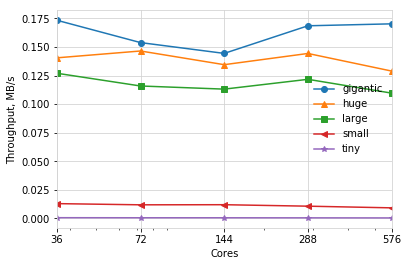

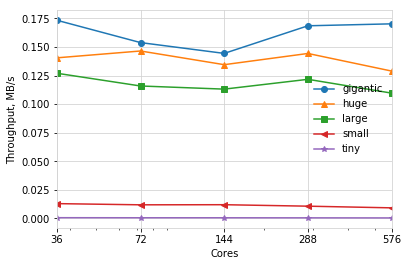

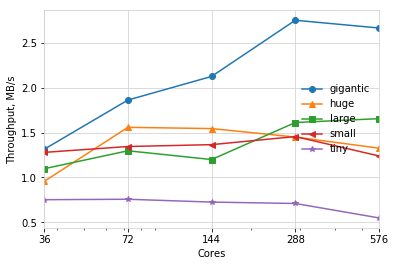

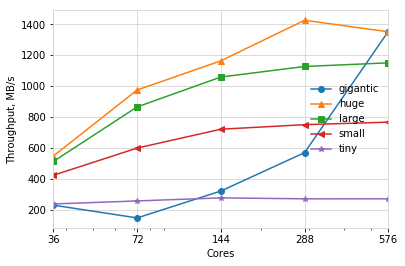

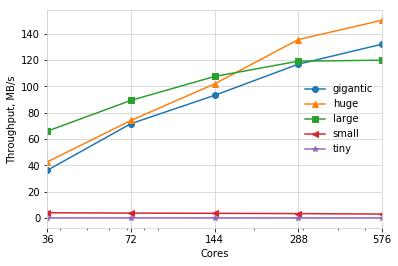

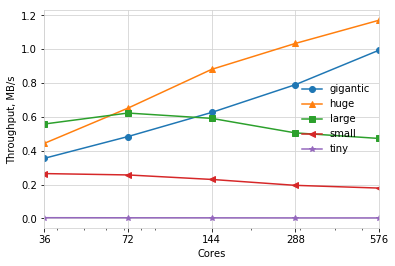

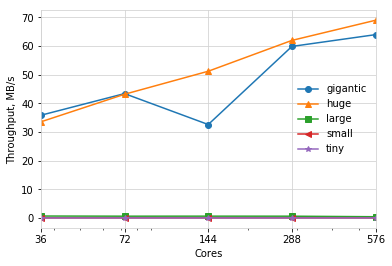

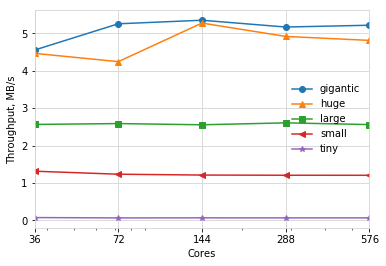

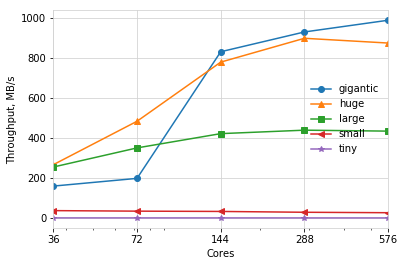

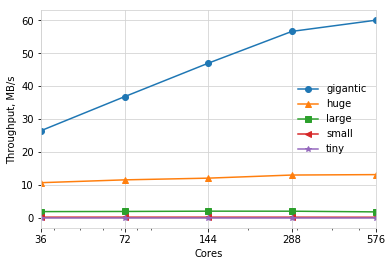

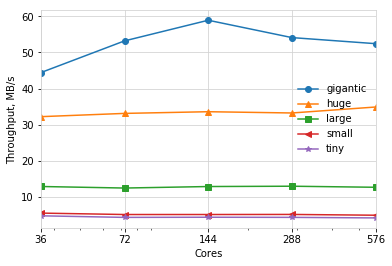

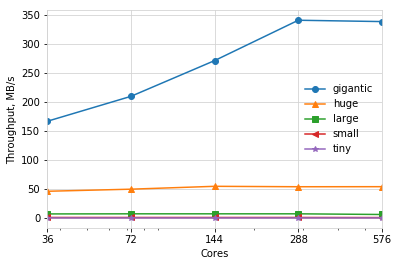

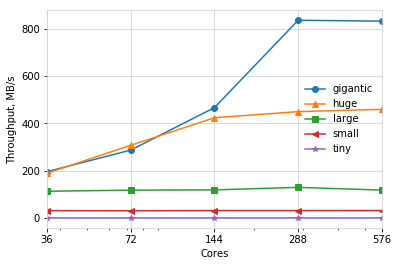

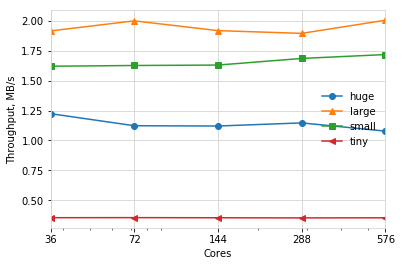

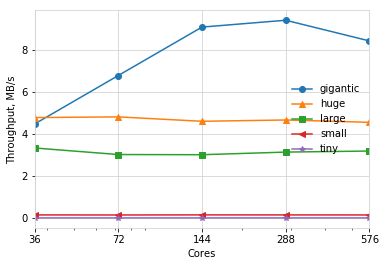

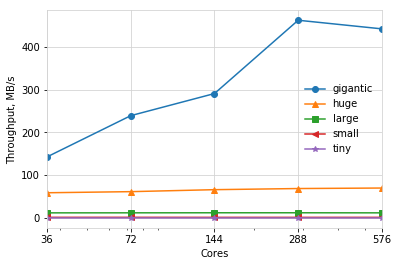

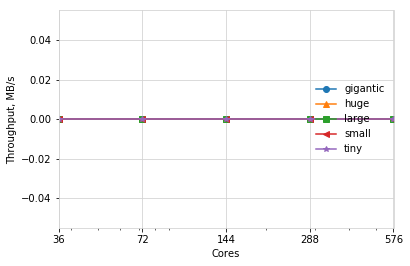

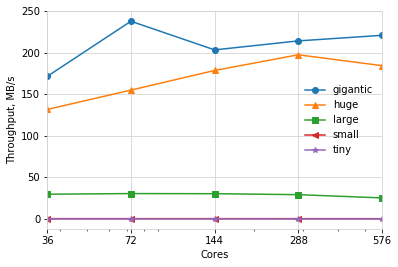

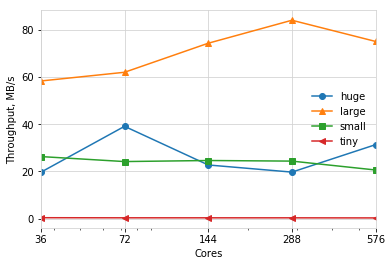

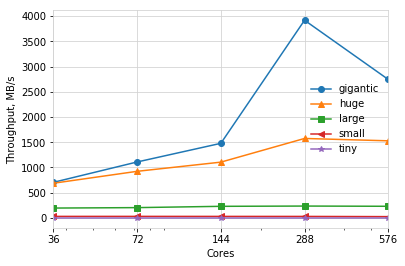

In [27]:
palette = 'o-', '^-', 's-', '<-', '*-'

def scaling_plot(measurements, y_axis_data = ('throughput', 'Throughput, MB/s')): #'log', ('duration', 'Duration, s')
    y_axis_field, y_axis_label = y_axis_data

    styles = itertools.cycle(palette)
    row = measurements.iloc[0]
    title = 'HiBench.{name} test'.format(name=row['name'])

    fig, ax = plt.subplots()
    for label, measurements_scale in measurements.groupby('scale'):
        style = next(styles)
        legend=measurements_scale['scale'].iloc[0]
        plt.plot(measurements_scale['ncores'], measurements_scale[y_axis_field], style, label=str(legend))

    ax.set_xscale("log")
    ax.set_yscale("log")

    nthreads = measurements_scale['ncores'].unique()
    ax.set_xticks(nthreads)
    ax.set_xticklabels(nthreads)
    plt.xlim((min(nthreads),max(nthreads)))
    ax.set_xlabel('Cores')
    ax.set_ylabel(y_axis_label)

    plt.grid(color='lightgray')
    ax.spines['bottom'].set_color('lightgray')
    ax.spines['top'].set_color('lightgray') 
    ax.spines['right'].set_color('lightgray')
    ax.spines['left'].set_color('lightgray')

    legend = ax.legend(loc="right", framealpha=0)

    plt.savefig('{}_{}_{}.png'.format('HiBench',row['name'],y_axis_field), dpi=300)
    return fig

scaling_plot_log = lambda measurements: scaling_plot(measurements)
scaling_plot_log = lambda measurements: scaling_plot(measurements), ('duration', 'Execution time (s)'))

measurements = measurements.groupby(['scale','name','ncores'], as_index=False).agg({'duration':'mean', 'data_size':'mean', 'throughput':'mean', 'node_throughput':'mean'})
plots_table = measurements.groupby(['name'])['scale', 'name', 'ncores', 'duration', 'throughput'].apply(scaling_plot_log)

# names = measurements['name'].unique()
names = ['LinearRegression', 'LogisticRegression', 'PCA', 'SVD', 'ScalaSparkAggregation', 'ScalaSparkJoin', 'ScalaSparkSort', 'ScalaSparkTerasort']
